# Assignment 2: Depth Estimation From Stereo and Video

In [1]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Noise Removal

In [8]:
def dist(c1, c2):
    dist = np.sum(np.absolute(c1 - c2))/3
    return dist

def add_weight(unary_cost, node, dist_src, dist_sink):
    unary_cost[node] = [dist_src, dist_sink]
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights

def construct_graph(img, m_lambda):
    height, width, colors = img.shape
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, 2])
    
    for x in range(height):
        for y in range(width):
            c = img[x, y]
            node = idxs[x, y]

            # data term:
            unary_cost = add_weight(unary_cost, node, dist(SOURCE_COLOR,c), dist(SINK_COLOR,c))

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

(573, 769, 3)
(573, 769, 1) <class 'numpy.ndarray'>
0 0 1
(573, 769, 1) <class 'numpy.ndarray'>
1 1 0
(573, 769, 1) <class 'numpy.ndarray'>
2 1 1
(573, 769, 1) <class 'numpy.ndarray'>
3 2 0
(573, 769, 1) <class 'numpy.ndarray'>
4 2 1


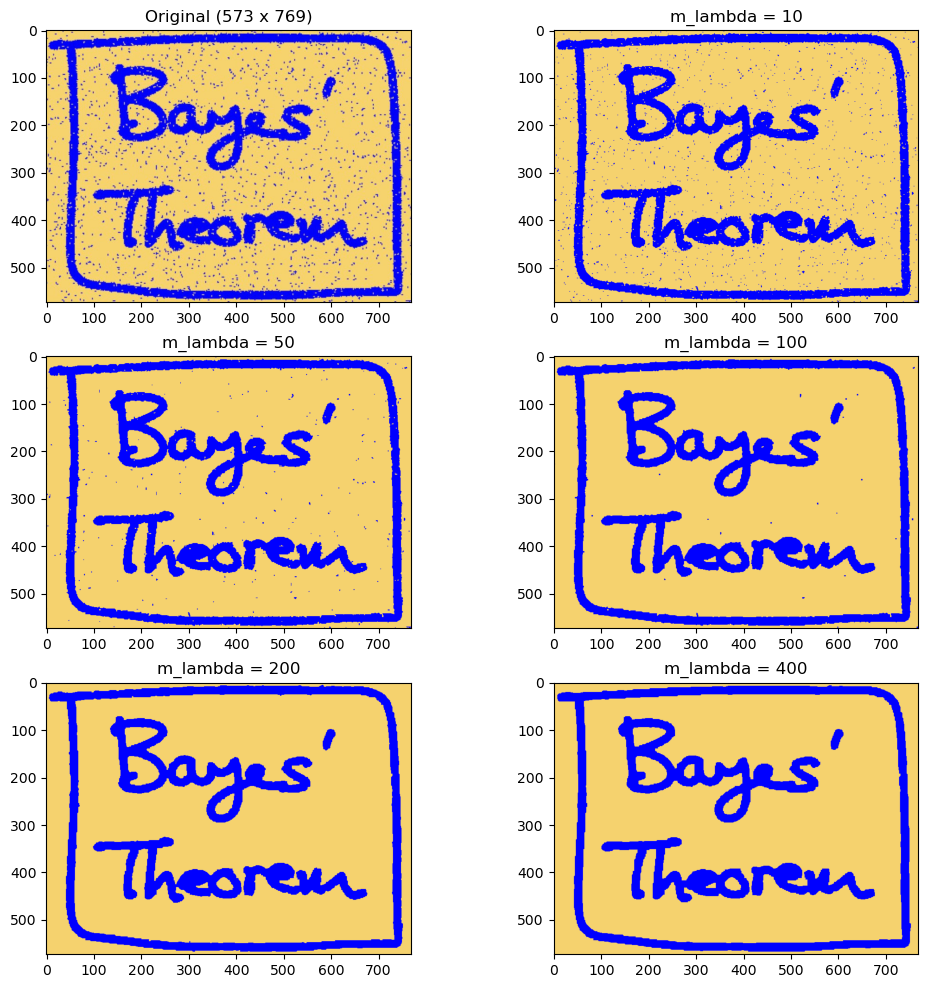

In [50]:
# Some global settings
m_lambdas = [10, 50, 100, 200, 400]; # change this value to change the weight of the smoothness or prior term
SOURCE_COLOR = np.array([0, 0, 255]); # blue = foreground
SINK_COLOR = np.array([245, 210, 110]); # yellow = background

# Read the input image
img = Image.open('media/bayes_in.jpg')
img = np.asarray(img)
print(img.shape)

# Display the original image
_, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0][0].imshow(np.array(img), cmap='gray')
ax[0][0].title.set_text('Original (%d x %d)' %(np.array(img).shape[0], np.array(img).shape[1]))

for n in range(len(m_lambdas)):
    m_lambda = m_lambdas[n]
    
    # Construct a graph
    edges, edge_weights, unary = construct_graph(img, m_lambda)
    pairwise = (1 - np.eye(2)) * 0.5
    
    # Apply graphcut to get labels
    labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
    labels = labels.reshape(img.shape[:2])
    labels = labels[..., np.newaxis]
    
    # Reconstruct the output image from labels
    img_bg = np.full_like(img, SINK_COLOR)
    img_fg = np.full_like(img, SOURCE_COLOR)
    img_out = labels*img_bg + (1-labels)*img_fg
    
    # Display the image
    i = int((n + 1)/2)
    j = int((n + 1)%2)
    ax[i][j].imshow(img_out)
    ax[i][j].title.set_text('m_lambda = %d' %m_lambda)
    

## Part 1: Noise Removal Observations

It can be viewed that by changing the parameter `m_lambda`, the noise removal result is significantly affected. A smaller value of `m_lambda` leaves more noise in the output image while a larger value of `m_lambda` is able to remove noise more throughtly. 

## Part 2: Depth from Rectified Stereo Images